# Environment simulation for Contextual Bandits

> In this notebook, we'll evaluate the performance of Linear Contextual Bandits in an MF-based environment. This environment will accept contextual (per-arm) features about users and items

* Environment will compute a low-rank matrix factorization (using SVD) of the `<user, item>` data matrix
* Use the movielens dataset to formulate an approximate item rating for each user (collaborative filtering)
* Train a linear RL algorithm, the [LinUCB](https://www.tensorflow.org/agents/tutorials/intro_bandit) agent, which incorporates exploration via boosting the estimates by an amount that corresponds to the variance of those estimates

**What are per-arm features?**
* In some bandits use cases, each arm has its own features. For example, in movie recommendation problems, the user features play the role of the context and the movies play the role of the arms (aka actions) 
* Each movie has its own features, such as `text description`, `metadata`, `trailer content` features and so on

These problems are often referred to as `arm features problems`

In [1]:
! python3 -c "import google.cloud.aiplatform; print('aiplatform SDK version: {}'.format(google.cloud.aiplatform.__version__))"

aiplatform SDK version: 1.33.1


## Load env config

* use the prefix from `00-env-setup`

In [2]:
# PREFIX = 'mabv1'
VERSION        = "v2"                       # TODO
PREFIX         = f'rec-bandits-{VERSION}'   # TODO

print(f"PREFIX: {PREFIX}")

PREFIX: rec-bandits-v2


**run the next cell to populate env vars**

In [3]:
# staging GCS
GCP_PROJECTS             = !gcloud config get-value project
PROJECT_ID               = GCP_PROJECTS[0]

# GCS bucket and paths
BUCKET_NAME              = f'{PREFIX}-{PROJECT_ID}-bucket'
BUCKET_URI               = f'gs://{BUCKET_NAME}'

config = !gsutil cat {BUCKET_URI}/config/notebook_env.py
print(config.n)
exec(config.n)


PROJECT_ID               = "hybrid-vertex"
PROJECT_NUM              = "934903580331"
LOCATION                 = "us-central1"

REGION                   = "us-central1"
BQ_LOCATION              = "US"
VPC_NETWORK_NAME         = "ucaip-haystack-vpc-network"

VERTEX_SA                = "934903580331-compute@developer.gserviceaccount.com"

PREFIX                   = "rec-bandits-v2"
VERSION                  = "v2"

BUCKET_NAME              = "rec-bandits-v2-hybrid-vertex-bucket"
BUCKET_URI               = "gs://rec-bandits-v2-hybrid-vertex-bucket"
DATA_GCS_PREFIX          = "data"
DATA_PATH                = "gs://rec-bandits-v2-hybrid-vertex-bucket/data"
VOCAB_SUBDIR             = "vocabs"
VOCAB_FILENAME           = "vocab_dict.pkl"
DATA_PATH_KFP_DEMO       = "gs://rec-bandits-v2-hybrid-vertex-bucket/data/kfp_demo_data/u.data"

VPC_NETWORK_FULL         = "projects/934903580331/global/networks/ucaip-haystack-vpc-network"

BIGQUERY_DATASET_NAME    = "mvlens_rec_bandits_v2"
BIGQUERY_TABLE_NA

In [4]:
# ! gsutil ls $BUCKET_URI

## imports

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [60]:
import functools
import json
from collections import defaultdict
from typing import Callable, Dict, List, Optional, TypeVar
from datetime import datetime
import time
from pprint import pprint
import pickle as pkl

import logging
logging.disable(logging.WARNING)

import matplotlib.pyplot as plt
import numpy as np

# google cloud
from google.cloud import aiplatform, storage

# tensorflow
import tensorflow as tf
from tf_agents.agents import TFAgent
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents.examples.v2 import trainer
from tf_agents.bandits.environments import (environment_utilities,
                                            movielens_py_environment,
                                            movielens_per_arm_py_environment)
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import TFEnvironment, tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.metrics.tf_metric import TFStepMetric
from tf_agents.policies import policy_saver

import collections
from tf_agents.bandits.replay_buffers import bandit_replay_buffer

# GPU
from numba import cuda 
import gc

# tf exceptions and vars
if tf.__version__[0] != "2":
    raise Exception("The trainer only runs with TensorFlow version 2.")

T = TypeVar("T")

import sys
sys.path.append("..")

# my project
from src import train_utils
from src import policy_util as policy_util
from src.data import data_config, mv_lookup_dicts
from src.environments import my_per_arm_py_env
from src.data import data_utils as data_utils

### detect GPUs & reset devices

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
device = cuda.get_current_device()
device.reset()
gc.collect()

14

### Initialize Google Cloud SDK Clients

In [10]:
# cloud storage client
storage_client = storage.Client(project=PROJECT_ID)

# Vertex client
aiplatform.init(project=PROJECT_ID, location=LOCATION)

# Data prep

In [11]:
EXAMPLE_GEN_GCS_PATH = data_config.EXAMPLE_GEN_GCS_PATH
GCS_DATA_PATH = f"{BUCKET_URI}/{EXAMPLE_GEN_GCS_PATH}"

print(f"GCS_DATA_PATH: {GCS_DATA_PATH}")

!gsutil ls $GCS_DATA_PATH

GCS_DATA_PATH: gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/val/
gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/vocabs/


In [12]:
EXISTING_VOCAB_FILE = f'gs://{BUCKET_NAME}/{EXAMPLE_GEN_GCS_PATH}/vocabs/{VOCAB_FILENAME}'
print(f"Downloading vocab...")

os.system(f'gsutil -q cp {EXISTING_VOCAB_FILE} .')
print(f"Downloaded vocab from: {EXISTING_VOCAB_FILE}\n")

filehandler = open(VOCAB_FILENAME, 'rb')
vocab_dict = pkl.load(filehandler)
filehandler.close()

# for key in vocab_dict.keys():
#     pprint(key)

Downloaded vocab from: gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/vocabs/vocab_dict.pkl



### Read TF Records

In [14]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.AUTO

In [15]:
SPLIT = "train" # "train" | "val"

train_files = []
for blob in storage_client.list_blobs(
    f"{BUCKET_NAME}", 
    prefix=f'{EXAMPLE_GEN_GCS_PATH}/{SPLIT}/', 
    # delimiter='/'
):
    if '.tfrecord' in blob.name:
        train_files.append(blob.public_url.replace("https://storage.googleapis.com/", "gs://"))
        
train_files

['gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/ml-1m-gen-001-of-008.tfrecord',
 'gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/ml-1m-gen-002-of-008.tfrecord',
 'gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/ml-1m-gen-003-of-008.tfrecord',
 'gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/ml-1m-gen-004-of-008.tfrecord',
 'gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/ml-1m-gen-005-of-008.tfrecord',
 'gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/ml-1m-gen-006-of-008.tfrecord',
 'gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/ml-1m-gen-007-of-008.tfrecord',
 'gs://rec-bandits-v2-hybrid-vertex-bucket/data/movielens/m1m/train/ml-1m-gen-008-of-008.tfrecord']

In [16]:
train_dataset = tf.data.TFRecordDataset(train_files)
train_dataset = train_dataset.map(data_utils._parse_function)

for x in train_dataset.batch(1).take(1):
    pprint(x)

{'target_movie_genres': <tf.Tensor: shape=(1, 10), dtype=string, numpy=
array([[b'Drama', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK', b'UNK',
        b'UNK', b'UNK']], dtype=object)>,
 'target_movie_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'1775'], dtype=object)>,
 'target_movie_rating': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([4.], dtype=float32)>,
 'target_movie_title': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Live Flesh (1997)'], dtype=object)>,
 'target_movie_year': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1997])>,
 'target_rating_timestamp': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([974612615])>,
 'user_age': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([50])>,
 'user_gender': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'M'], dtype=object)>,
 'user_id': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'2173'], dtype=object)>,
 'user_occupation_text': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'prog

# Define RL modules

## set hyperparameters

In [17]:
# Set hyperparameters.
BATCH_SIZE       = 128      # Training and prediction batch size.

# Set MovieLens simulation environment parameters.
RANK_K           = 5     # Rank for matrix factorization in the MovieLens environment; also the observation dimension.
NUM_ACTIONS      = 5     # Number of actions (movie items) to choose from.
PER_ARM          = True   # Use the non-per-arm version of the MovieLens environment.

# Set agent parameters.
TIKHONOV_WEIGHT  = 0.001   # LinUCB Tikhonov regularization weight.
AGENT_ALPHA      = 10.0    # LinUCB exploration parameter that multiplies the confidence intervals.

print(f"BATCH_SIZE       : {BATCH_SIZE}")
print(f"RANK_K           : {RANK_K}")
print(f"NUM_ACTIONS      : {NUM_ACTIONS}")
print(f"PER_ARM          : {PER_ARM}")
print(f"TIKHONOV_WEIGHT  : {TIKHONOV_WEIGHT}")
print(f"AGENT_ALPHA      : {AGENT_ALPHA}")

BATCH_SIZE       : 128
RANK_K           : 5
NUM_ACTIONS      : 5
PER_ARM          : True
TIKHONOV_WEIGHT  : 0.001
AGENT_ALPHA      : 10.0


## Define RL environment

One can define a bandit environment by subclassing `BanditTFEnvironment`, or, similarly to RL environments, one can define a `BanditPyEnvironment` and wrap it with `TFPyEnvironment`

> See `src.per_arm_rl.my_per_arm_py_env.py` for an example custom environment which implements a per-arm version of the MovieLens environment

In [22]:
env = my_per_arm_py_env.MyMovieLensPerArmPyEnvironment(
    project_number = PROJECT_NUM
    , data_path = DATA_PATH
    , bucket_name = BUCKET_NAME
    , data_gcs_prefix = f"{EXAMPLE_GEN_GCS_PATH}/{SPLIT}"
    , user_age_lookup_dict = mv_lookup_dicts.USER_AGE_LOOKUP
    , user_occ_lookup_dict = mv_lookup_dicts.USER_OCC_LOOKUP
    # , movie_gen_lookup_dict = mv_lookup_dicts.MOVIE_GEN_LOOKUP
    , num_users = mv_lookup_dicts.MOVIELENS_NUM_USERS
    , num_movies = mv_lookup_dicts.MOVIELENS_NUM_MOVIES
    , rank_k = RANK_K
    , batch_size = BATCH_SIZE
    , num_actions = NUM_ACTIONS
)

environment = tf_py_environment.TFPyEnvironment(env)

### inspect environment

In [23]:
environment.observation_spec()

{'global': TensorSpec(shape=(7,), dtype=tf.float32, name=None),
 'per_arm': TensorSpec(shape=(5, 6), dtype=tf.float32, name=None)}

In [24]:
environment.time_step_spec()

TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': {'global': TensorSpec(shape=(7,), dtype=tf.float32, name=None),
                 'per_arm': TensorSpec(shape=(5, 6), dtype=tf.float32, name=None)},
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [25]:
environment.action_spec()

BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(4, dtype=int32))

In [26]:
environment.batch_size

128

## Define Bandit Agent

In [27]:
agent = lin_ucb_agent.LinearUCBAgent(
    time_step_spec = environment.time_step_spec()
    , action_spec = environment.action_spec()
    , tikhonov_weight = TIKHONOV_WEIGHT
    , alpha = AGENT_ALPHA
    , dtype = tf.float32
    , accepts_per_arm_features = PER_ARM
    , summarize_grads_and_vars = True
    , enable_summaries = True
)

agent.initialize()

print("TimeStep Spec (for each batch):\n", agent.time_step_spec, "\n")
print("Action Spec (for each batch)  :\n", agent.action_spec, "\n")
print("Reward Spec (for each batch)  :\n", environment.reward_spec(), "\n")

TimeStep Spec (for each batch):
 TimeStep(
{'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'observation': DictWrapper({'global': TensorSpec(shape=(7,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(5, 6), dtype=tf.float32, name=None)}),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')}) 

Action Spec (for each batch)  :
 BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(4, dtype=int32)) 

Reward Spec (for each batch)  :
 TensorSpec(shape=(), dtype=tf.float32, name='reward') 



In [28]:
global_step = tf.compat.v1.train.get_or_create_global_step()

# saver = policy_saver.PolicySaver(
#     agent.policy, 
#     train_step=global_step
# )

#### The flow of training data

First, let us have a look at the data specification in the agent. The `training_data_spec` attribute of the agent specifies what elements and structure the training data should have.

In [29]:
print('training data spec: ', agent.training_data_spec)

training data spec:  Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(4, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(7,), dtype=tf.float32, name=None)}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=(), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(6,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})


If we have a closer look to the `observation` part of the spec, we see that it does not contain per-arm features!

In [30]:
print('observation spec in training: ', agent.training_data_spec.observation)

observation spec in training:  {'global': TensorSpec(shape=(7,), dtype=tf.float32, name=None)}


What happened to the per-arm features? To answer this question, first we note that when the LinUCB agent trains, it does not need the per-arm features of all arms, it only needs those of the **chosen arm**. Hence, it makes sense to drop the tensor of shape `[BATCH_SIZE, NUM_ACTIONS, PER_ARM_DIM]`, as it is very wasteful, especially if the number of actions is large.

But still, the per-arm features of the chosen arm must be somewhere! To this end, we make sure that the LinUCB policy stores the features of the chosen arm within the `policy_info` field of the training data:

In [31]:
print('chosen arm features: ', agent.training_data_spec.policy_info.chosen_arm_features)

chosen arm features:  TensorSpec(shape=(6,), dtype=tf.float32, name=None)


In [32]:
data_spec = agent.policy.trajectory_spec
print('data_spec: ', data_spec)

data_spec:  Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(4, dtype=int32)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(7,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(5, 6), dtype=tf.float32, name=None)}),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=(), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(6,), dtype=tf.float32, name=None)),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})


## Define RL metrics

Bandits' most important metric is **regret**, calculated as the difference between the reward collected by the agent and the expected reward of an oracle policy that has access to the reward functions of the environment. The [RegretMetric](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/metrics/tf_metrics.py) thus needs a `baseline_reward_fn` function that calculates the best achievable expected reward given an observation. For our example, we need to take the maximum of the no-noise equivalents of the reward functions that we already defined for the environment.

In [33]:
optimal_reward_fn = functools.partial(
    train_utils.compute_optimal_reward_with_my_environment
    , environment=environment
)

regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)
regret_metric

In [34]:
optimal_action_fn = functools.partial(
    train_utils.compute_optimal_action_with_my_environment,
    environment=environment,
)
    
suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(
  optimal_action_fn
)
suboptimal_arms_metric

In [35]:
bandit_metrics = [regret_metric, suboptimal_arms_metric]
bandit_metrics

In [36]:
# ====================================================
# metrics
# ====================================================
# `step_metric` records the number of individual rounds of bandit interaction;
# that is, (number of trajectories) * batch_size.

step_metric = tf_metrics.EnvironmentSteps()

metrics = [
    tf_metrics.NumberOfEpisodes()
    , tf_metrics.EnvironmentSteps()
    , tf_metrics.AverageEpisodeLengthMetric(batch_size=environment.batch_size)
]
if bandit_metrics:
    metrics += bandit_metrics

if isinstance(environment.reward_spec(), dict):
    metrics += [
        tf_metrics.AverageReturnMultiMetric(
            reward_spec=environment.reward_spec()
            , batch_size=environment.batch_size
        )
    ]
else:
    metrics += [
        tf_metrics.AverageReturnMetric(batch_size=environment.batch_size)
    ]
    
# Store intermediate metric results, indexed by metric names.
metric_results = collections.defaultdict(list)
    
metrics

## Prep training job

A **policy** in a bandit problem works the same way as in an RL problem: it provides an action (or a distribution of actions), given an observation as input.
* For more details, see the [TF-Agents Policy tutorial](https://github.com/tensorflow/agents/blob/master/docs/tutorials/3_policies_tutorial.ipynb).
* As with environments, there are two ways to construct a policy: One can create a `PyPolicy` and wrap it with `TFPyPolicy`, or directly create a `TFPolicy`

**Replay buffers**
* Reinforcement learning algorithms use `replay buffers` to store trajectories of experience when executing a policy in an environment. * During training, replay buffers are queried for a subset of the trajectories (either a sequential subset or a sample) to "replay" the agent's experience.

### set Vertex Exeperiment

In [37]:
EXPERIMENT_NAME   = f'01-offline-sim-mfenv-v2-{PREFIX}'

invoke_time       = time.strftime("%Y%m%d-%H%M%S")
RUN_NAME          = f'run-{invoke_time}'

CHECKPT_DIR       = f"{BUCKET_URI}/{EXPERIMENT_NAME}/chkpoint"
BASE_OUTPUT_DIR   = f"{BUCKET_URI}/{EXPERIMENT_NAME}/{RUN_NAME}"
LOG_DIR           = f"{BASE_OUTPUT_DIR}/logs"
ROOT_DIR          = f"{BASE_OUTPUT_DIR}/root"
ARTIFACTS_DIR     = f"{BASE_OUTPUT_DIR}/artifacts"  # Where the trained model will be saved and restored.

print(f"EXPERIMENT_NAME   : {EXPERIMENT_NAME}")
print(f"RUN_NAME          : {RUN_NAME}\n")
print(f"CHECKPT_DIR       : {CHECKPT_DIR}")
print(f"BASE_OUTPUT_DIR   : {BASE_OUTPUT_DIR}")
print(f"LOG_DIR           : {LOG_DIR}")
print(f"ROOT_DIR          : {ROOT_DIR}")
print(f"ARTIFACTS_DIR     : {ARTIFACTS_DIR}")

EXPERIMENT_NAME   : 01-offline-sim-mfenv-v2-rec-bandits-v2
RUN_NAME          : run-20240305-204044

CHECKPT_DIR       : gs://rec-bandits-v2-hybrid-vertex-bucket/01-offline-sim-mfenv-v2-rec-bandits-v2/chkpoint
BASE_OUTPUT_DIR   : gs://rec-bandits-v2-hybrid-vertex-bucket/01-offline-sim-mfenv-v2-rec-bandits-v2/run-20240305-204044
LOG_DIR           : gs://rec-bandits-v2-hybrid-vertex-bucket/01-offline-sim-mfenv-v2-rec-bandits-v2/run-20240305-204044/logs
ROOT_DIR          : gs://rec-bandits-v2-hybrid-vertex-bucket/01-offline-sim-mfenv-v2-rec-bandits-v2/run-20240305-204044/root
ARTIFACTS_DIR     : gs://rec-bandits-v2-hybrid-vertex-bucket/01-offline-sim-mfenv-v2-rec-bandits-v2/run-20240305-204044/artifacts


### Create TensorBoard

In [38]:
NEW_TENSORBOARD = True

In [39]:
if NEW_TENSORBOARD:
    # # create new TB instance
    TENSORBOARD_DISPLAY_NAME=f"{EXPERIMENT_NAME}"

    tensorboard = aiplatform.Tensorboard.create(
        display_name=TENSORBOARD_DISPLAY_NAME
        , project=PROJECT_ID
        , location=REGION
    )

    TB_RESOURCE_NAME = tensorboard.resource_name
else:
    # use existing TB instance
    TB_RESOURCE_NAME = 'projects/934903580331/locations/us-central1/tensorboards/4499557822626791424'
    tensorboard = aiplatform.Tensorboard(
        tensorboard_name=TB_RESOURCE_NAME
    )

TB_ID = TB_RESOURCE_NAME.split('/')[-1]

print(f"TB_RESOURCE_NAME : {TB_RESOURCE_NAME}")
print(f"TB display name  : {tensorboard.display_name}")
print(f"TB_ID            : {TB_ID}")

TB_RESOURCE_NAME : projects/934903580331/locations/us-central1/tensorboards/8286522159291957248
TB display name  : 01-offline-sim-mfenv-v2-rec-bandits-v2
TB_ID            : 8286522159291957248


In [40]:
aiplatform.init(
    project=PROJECT_ID,
    location=REGION,
    experiment=EXPERIMENT_NAME,
    experiment_tensorboard=TB_ID
)

### Define replay buffer

In [41]:
TRAINING_LOOPS   = 50     # Number of training iterations.
STEPS_PER_LOOP   = 1      # Number of driver steps per training iteration.
print(f"TRAINING_LOOPS   : {TRAINING_LOOPS}")
print(f"STEPS_PER_LOOP   : {STEPS_PER_LOOP}")

TRAINING_LOOPS   : 50
STEPS_PER_LOOP   : 1


In [42]:
def _get_replay_buffer(
    data_spec, batch_size, steps_per_loop, async_steps_per_loop
):
    """Return a `TFUniformReplayBuffer` for the given `agent`."""
    return bandit_replay_buffer.BanditReplayBuffer(
        data_spec=data_spec,
        batch_size=batch_size,
        max_length=steps_per_loop * async_steps_per_loop,
    )

replay_buffer = _get_replay_buffer(
    data_spec = data_spec
    , batch_size = environment.batch_size
    , steps_per_loop = STEPS_PER_LOOP
    , async_steps_per_loop = 1
)

### Logging and checkpointing

In [43]:
summary_writer = tf.summary.create_file_writer(LOG_DIR)
summary_writer.set_as_default()

# ====================================================
# get checkpoint manager
# ====================================================
print(f"setting checkpoint_manager: {CHECKPT_DIR}\n")
checkpoint_manager = train_utils.restore_and_get_checkpoint_manager(
    root_dir=CHECKPT_DIR, 
    agent=agent, 
    metrics=metrics, 
    step_metric=step_metric
)
# # ====================================================
# # policy saver
# # ====================================================
# POLICY_DIR = os.path.join(TMP_DIR, 'policy')
# print(f"setting POLICY_DIR: {POLICY_DIR}\n")
# saver = policy_saver.PolicySaver(
#     agent.policy, 
#     train_step=global_step
# )
# print(f"saver: {saver}")

setting checkpoint_manager: gs://rec-bandits-v2-hybrid-vertex-bucket/01-offline-sim-mfenv-v2-rec-bandits-v2/chkpoint



### Driver

In [44]:
print(f"TRAINING_LOOPS   : {TRAINING_LOOPS}")
print(f"STEPS_PER_LOOP   : {STEPS_PER_LOOP}")

TRAINING_LOOPS   : 50
STEPS_PER_LOOP   : 1


In [45]:
add_batch_fn = replay_buffer.add_batch

observers = [add_batch_fn, step_metric] + metrics

driver = dynamic_step_driver.DynamicStepDriver(
    env=environment
    , policy=agent.collect_policy
    , num_steps=STEPS_PER_LOOP * environment.batch_size
    , observers=observers
)

### Training loop

In [46]:
from tf_agents.metrics import export_utils

def set_expected_shape(experience, num_steps):
    """Sets expected shape."""

    def set_time_dim(input_tensor, steps):
        tensor_shape = input_tensor.shape.as_list()
        if len(tensor_shape) < 2:
            raise ValueError(
                'input_tensor is expected to be of rank-2, but found otherwise: '
                f'input_tensor={input_tensor}, tensor_shape={tensor_shape}'
            )
        tensor_shape[1] = steps
        input_tensor.set_shape(tensor_shape)

    tf.nest.map_structure(lambda t: set_time_dim(t, num_steps), experience)

def _get_training_loop(
    driver, replay_buffer, agent, steps, async_steps_per_loop, log_interval=10
):
    """Returns a `tf.function` that runs the driver and training loops.

    Args:
    driver: an instance of `Driver`.
    replay_buffer: an instance of `ReplayBuffer`.
    agent: an instance of `TFAgent`.
    steps: an integer indicating how many driver steps should be executed and
      presented to the trainer during each training loop.
    async_steps_per_loop: an integer. In each training loop, the driver runs
      this many times, and then the agent gets asynchronously trained over this
      many batches sampled from the replay buffer.
    """

    def _export_metrics_and_summaries(step, metrics):
        """Exports metrics and tf summaries."""
        metric_utils.log_metrics(metrics)
        export_utils.export_metrics(step=step, metrics=metrics)
        for metric in metrics:
            metric.tf_summaries(train_step=step)

    def training_loop(train_step, metrics):
        """Returns a function that runs a single training loop and logs metrics."""
        for batch_id in range(async_steps_per_loop):
            driver.run()
            _export_metrics_and_summaries(
                step=train_step * async_steps_per_loop + batch_id, metrics=metrics
            )
        batch_size = driver.env.batch_size
        dataset_it = iter(
            replay_buffer.as_dataset(
                sample_batch_size=batch_size,
                num_steps=steps,
                single_deterministic_pass=True,
            )
        )
        for batch_id in range(async_steps_per_loop):
            experience, unused_buffer_info = dataset_it.get_next()
            set_expected_shape(experience, steps)
            loss_info = agent.train(experience)
            export_utils.export_metrics(
                step=train_step * async_steps_per_loop + batch_id,
                metrics=[],
                loss_info=loss_info,
            )
            if train_step % log_interval == 0:
                # print(
                #     f'step = {train_step}: train loss = {round(loss_info.loss.numpy(), 2)}'
                # )
                tf.print(
                    'step = {0}: loss = {1}'.format(
                        train_step, round(loss_info.loss.numpy(), 2)
                    )
                )

        replay_buffer.clear()

    return training_loop

In [47]:
training_loop = _get_training_loop(
    driver = driver
    , replay_buffer = replay_buffer
    , agent = agent
    , steps = STEPS_PER_LOOP
    , async_steps_per_loop = 1
)

## Run training loop

In [48]:
start_time = time.time()

for train_step in range(TRAINING_LOOPS):

    # training loop
    training_loop(
        train_step = train_step
        , metrics = metrics
    )

    # log tensorboard
    for metric in metrics:
        metric.tf_summaries(
            train_step=train_step
            , step_metrics=metrics[:2]
        )

    metric_utils.log_metrics(metrics)

    for metric in metrics:
        metric.tf_summaries(train_step = step_metric.result())
        metric_results[type(metric).__name__].append(metric.result().numpy())

runtime_mins = int((time.time() - start_time) / 60)
tf.print(f"runtime_mins: {runtime_mins}")

checkpoint_manager.save(global_step)
tf.print(f"saved policy checkpoint to: {CHECKPT_DIR}")

step = 0: loss = 0.49000000953674316
step = 10: loss = 0.3499999940395355
step = 20: loss = 0.25
step = 30: loss = 0.27000001072883606
step = 40: loss = 0.14000000059604645
runtime_mins: 2
saved policy checkpoint to: gs://rec-bandits-v2-hybrid-vertex-bucket/01-offline-sim-mfenv-v2-rec-bandits-v2/chkpoint


In [49]:
# metric_results

In [50]:
pprint(metric_results.keys())

dict_keys(['NumberOfEpisodes', 'EnvironmentSteps', 'AverageEpisodeLengthMetric', 'RegretMetric', 'SuboptimalArmsMetric', 'AverageReturnMetric'])


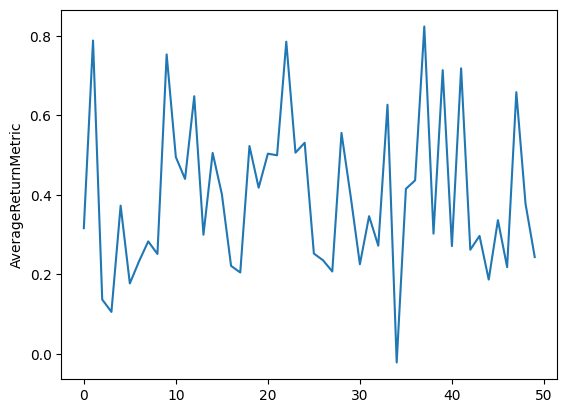

In [51]:
plt.plot(metric_results['AverageReturnMetric'])
plt.ylabel('AverageReturnMetric')
plt.show()

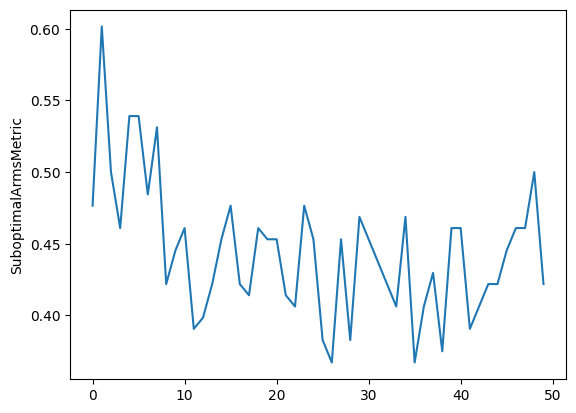

In [52]:
plt.plot(metric_results['SuboptimalArmsMetric'])
plt.ylabel('SuboptimalArmsMetric')
plt.show()

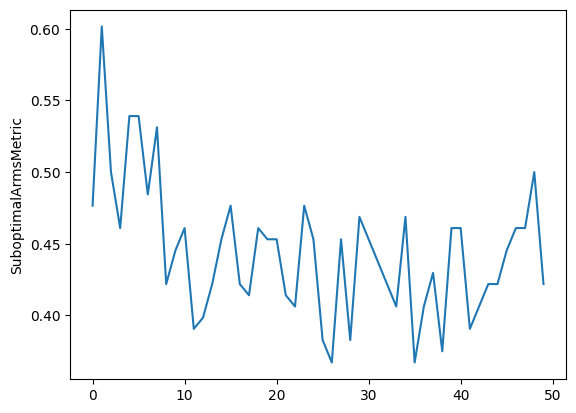

In [53]:
plt.plot(metric_results['SuboptimalArmsMetric'])
plt.ylabel('SuboptimalArmsMetric')
plt.show()

# [2] Optional: Run with src modules

> accomplish same steps as above in [1], except use modules in `src/..`

In [61]:
TEST_HPT_FLAG  = False # True | False

_ARTIFACTS_DIR = ARTIFACTS_DIR if not TEST_HPT_FLAG else None
_ROOT_DIR      = ROOT_DIR if not TEST_HPT_FLAG else None

print(f"TEST_HPT_FLAG  : {TEST_HPT_FLAG}")
print(f"_ARTIFACTS_DIR : {_ARTIFACTS_DIR}")
print(f"_ROOT_DIR      : {_ROOT_DIR}")

TEST_HPT_FLAG  : False
_ARTIFACTS_DIR : gs://rec-bandits-v2-hybrid-vertex-bucket/01-offline-sim-mfenv-v2-rec-bandits-v2/run-20240305-204044/artifacts
_ROOT_DIR      : gs://rec-bandits-v2-hybrid-vertex-bucket/01-offline-sim-mfenv-v2-rec-bandits-v2/run-20240305-204044/root


In [62]:
# from src import policy_util as policy_util

In [63]:
#start the timer and training
start_time = time.time()

metric_results = policy_util.train(
    agent=agent,
    environment=environment,
    log_dir=LOG_DIR,
    # model_dir = BASE_OUTPUT_DIR,
    chkpt_dir = CHECKPT_DIR,
    training_loops=TRAINING_LOOPS,
    steps_per_loop=STEPS_PER_LOOP,
    additional_metrics=metrics,
    # save_policy=True,
    artifacts_dir=_ARTIFACTS_DIR,
    root_dir=_ROOT_DIR,
    run_hyperparameter_tuning=TEST_HPT_FLAG,
    profiler = False,
    train_summary_writer = summary_writer,
    chkpt_interval = 10,
    global_step = global_step,
)

end_time = time.time()
runtime_mins = int((end_time - start_time) / 60)
print(f"train runtime_mins: {runtime_mins}")

step = 0: train loss = 0.2199999988079071
step = 10: train loss = 0.25
step = 20: train loss = 0.3199999928474426
step = 30: train loss = 0.20999999344348907
step = 40: train loss = 0.10999999940395355
runtime_mins: 3
saved policy checkpoint to: gs://rec-bandits-v2-hybrid-vertex-bucket/01-offline-sim-mfenv-v2-rec-bandits-v2/chkpoint
train runtime_mins: 3


In [64]:
pprint(metric_results.keys())

dict_keys(['NumberOfEpisodes', 'EnvironmentSteps', 'AverageEpisodeLengthMetric', 'RegretMetric', 'SuboptimalArmsMetric', 'AverageReturnMetric'])


In [65]:
# metric_results['AverageReturnMetric']

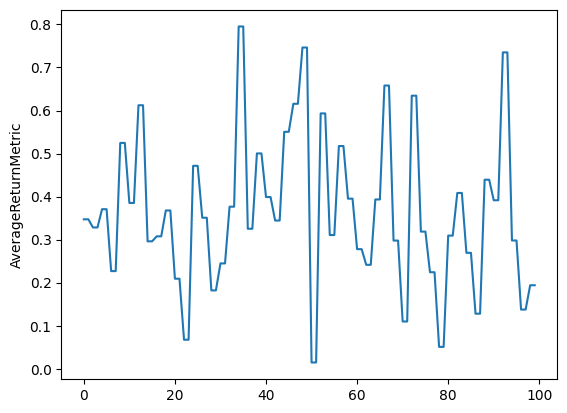

In [66]:
import matplotlib.pyplot as plt

plt.plot(metric_results['AverageReturnMetric'])
plt.ylabel('AverageReturnMetric')
plt.show()

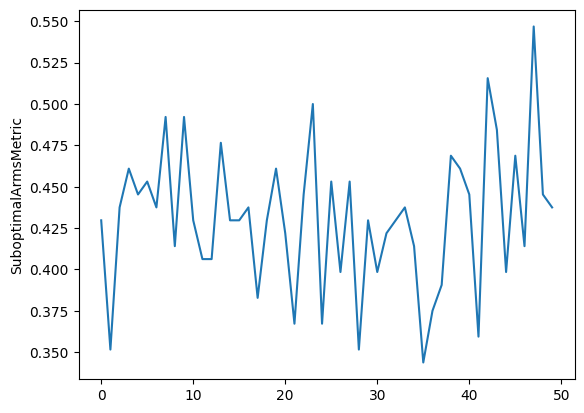

In [67]:
plt.plot(metric_results['SuboptimalArmsMetric'])
plt.ylabel('SuboptimalArmsMetric')
plt.show()

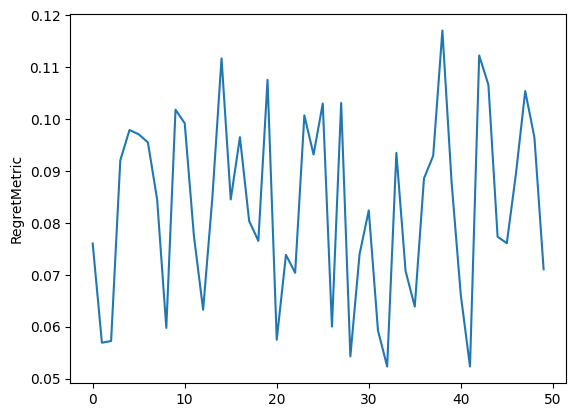

In [68]:
plt.plot(metric_results['RegretMetric'])
plt.ylabel('RegretMetric')
plt.show()

### TensorBoard

In [69]:
# %load_ext tensorboard
%reload_ext tensorboard

In [70]:
%tensorboard --logdir=$LOG_DIR

**Finished**